In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort

In [2]:

def stereo_depth_estimation(left_img_path, right_img_path, num_disparities=16*6, block_size=15):
    imgL = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)
    	
    imgL = imgL[0:319, 0:264]
    imgR = imgR[0:319, 0:264]
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * block_size ** 2,
        P2=32 * 3 * block_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )

    disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    disp_norm = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
    disp_norm = np.uint8(disp_norm)
    return disparity, disp_norm



In [9]:

def midas_onnxruntime_depth_estimation(img_path, model_path='model-small.onnx'):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_size = 256
    img_resized = cv2.resize(img_rgb, (input_size, input_size)).astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_normalized = (img_resized - mean) / std
    input_tensor = img_normalized.transpose(2, 0, 1)[None, :, :, :].astype(np.float32)
    ort_session = ort.InferenceSession(model_path)

    input_name = ort_session.get_inputs()[0].name
    outputs = ort_session.run(None, {input_name: input_tensor})

    depth_map = outputs[0][0, :, :]
    depth_map_resized = cv2.resize(depth_map, (img.shape[1], img.shape[0]))
    depth_min = depth_map_resized.min()
    depth_max = depth_map_resized.max()
    depth_vis = (depth_map_resized - depth_min) / (depth_max - depth_min)
    depth_vis = (depth_vis * 255).astype(np.uint8)

    return depth_map_resized, depth_vis

In [10]:
def visualize_results(left_img_path, right_img_path, onnx_model_path):
    disparity, disparity_vis = stereo_depth_estimation(left_img_path, right_img_path)
    depth_map, depth_vis = midas_onnxruntime_depth_estimation(left_img_path, onnx_model_path)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    imgL = cv2.imread(left_img_path)
    plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
    plt.title('Left Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    imgR = cv2.imread(right_img_path)
    plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
    plt.title('Right Image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(disparity_vis, cmap='plasma')
    plt.title('Stereo Disparity Map (OpenCV)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(depth_vis, cmap='plasma')
    plt.title('Depth Map (MiDaS ONNX Runtime)')
    plt.axis('off')

    plt.show()


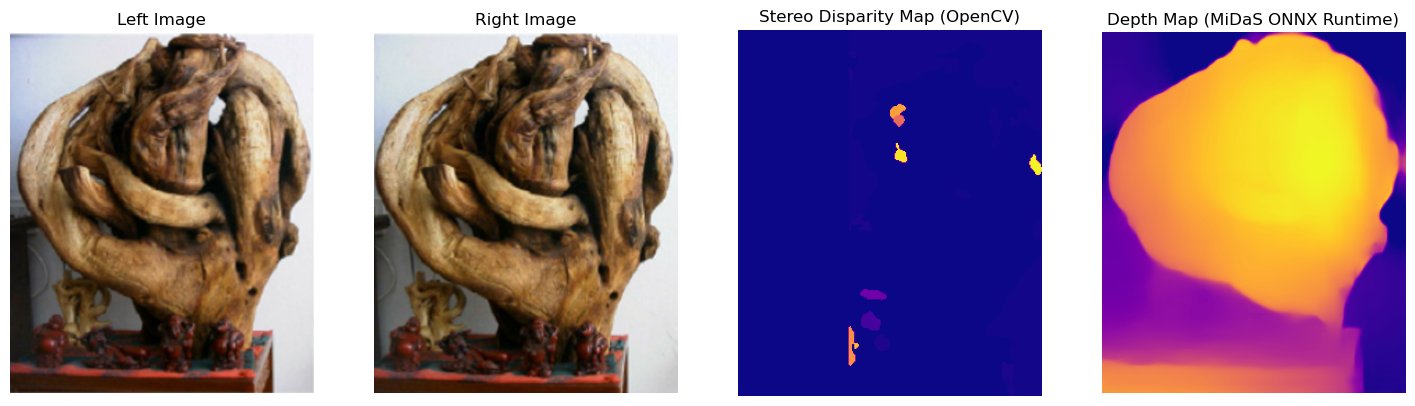

In [11]:

left_image_path = "Left.png"
right_image_path = "Right.png"
onnx_model_path = "model-small.onnx"  
# imgL = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)
# cv2.imshow("img", imgL)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
visualize_results(left_image_path, right_image_path, onnx_model_path)
